In [12]:
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [13]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [14]:
# Code from previous excercises

# Downloading a sample of MNIST containing just 3 and 7s supplied by fastai
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

# Creating the Training Set
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
dataset = list(zip(train_x, train_y))

# Creating the Validation Set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dataset = list(zip(valid_x, valid_y))

# Creating DataLoaders
dl = DataLoader(dataset, batch_size=256)
valid_dl = DataLoader(valid_dataset, batch_size=256)

# Initialising Parameters
def init_params(size, var=1.0): return (torch.randn(size)*var).requires_grad_()

# Defining the Loss Function
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()
    
# Calculating Gradients
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

# Calculating Validation Accuracy
def batch_accuracy(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)

# Creating DataLoaders object
dls = DataLoaders(dl, valid_dl)

# Adding a Nonlinearity

So far, we have a general procedure for optimising the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something non-linear between two linear classifiers - this is what gives us a neural network.

Here is the entire definition of a basic neural network.

In [15]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors which are parameters that are initially randomised.

In [16]:
w1 = init_params((28*28, 30))
b1 = init_params(30)

w2 = init_params((30, 1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

The little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. All it does is replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`.

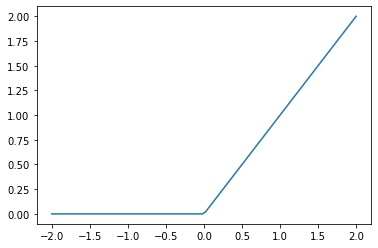

In [17]:
plot_function(F.relu)

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and add them up multiple times, that could be replaced by multiplying different things together and adding them up just once. That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a non-linear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other one, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

Amazingly enough, it can be mathematically prove that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. This is known as the *universal approximation theorem*. The three lines of code that we have above are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as *nonlinearity* or **activation function**.

Taking advantage of PyTorch, we can replace the above code with something simpler.

In [18]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1),
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()`.

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of the modules it contains.
Let's try it out with a lower learning rate and a few more epochs.

In [19]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [20]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.288289,0.413854,0.504416,00:00
1,0.137698,0.222317,0.812071,00:00
2,0.077730,0.113751,0.916585,00:00
3,0.052016,0.077751,0.940137,00:00
4,0.039915,0.061019,0.955348,00:00
5,0.033623,0.051468,0.963199,00:00
6,0.029940,0.045399,0.966634,00:00
7,0.027513,0.041244,0.966143,00:00
8,0.025752,0.038229,0.968106,00:00
9,0.024382,0.035937,0.969578,00:00


As the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, we can plot the accuracy over training as follows.


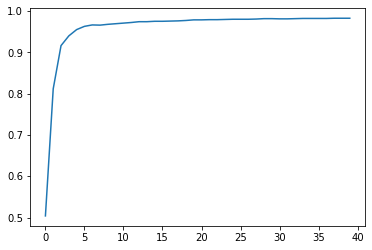

In [21]:
plt.plot(L(learn.recorder.values).itemgot(2))

And we can view the final accuracy.

In [22]:
learn.recorder.values[-1][2]

0.982826292514801

At this point, we have something that is amazing.
1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
2. A way to find the best set of parameters for any function (stochastic gradient descent)

## Going Deeper

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a non-linearity between each pair of linear layers. However, the deeper the model gets, the harder it is to optimise the parameters in practice.

With a deeper model, we do not need to use as many parameters. It turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and fewer layers. That means we can train the model more quickly, and it will take up less memory.

Here is what happens when we train an 18-layer model using the same approach we saw previously.

In [25]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                          loss_func=F.cross_entropy, metrics=accuracy)

learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.085801,0.008483,0.997547,03:27
